# Survival Game 
<font size=4 color='gray'>Alexander Bruun, Anton Paris </font>
# <font color='gray'>A Predator Prey Simulation </font>
Based on Leonel Aguilar's 2D Cellular Automata Code
***




## Overview    <font size=3 color='gray'> -  Table of content for faster Navigation </font>
***

-  [<b>Import Libraries</b>](#import)   <br>
<br>
-  [ <b>User Imput</b>](#user) <br>
&ensp; [Meaning of the index in Lists](#meaning_list)<br>
<br>
-  [<b>Class Cell</b>](#cell) <br>
&ensp; [Properties of the Class Cell](#properties)<br>
&ensp; [Class Cell, declaration of functions and attributes](#functions_cell)<br>
<br>
-  [<b>Generate 2D List with cells</b>](#build_cells)<br> 
&ensp; [Get Informations out of Grid](#information_grid)<br> 
&ensp; [Test if Grid is initialized correct](#test_grid)<br>
<br>
-  [<b>Define Neighborhood</b>](#define_n) <br>
&ensp; [Test if Neighborhood is extraxted the correct way](#test_neighborhood)<br> 
&ensp; [Filter possible neighbor cells out](#filter_neighborhood)<br> 
<br>
-  [<b>Apply rule function</b>](#apply) <br>
&ensp; [Idea of the function](#idea_apply)<br> 
&ensp; [The rules of the apply rule function](#rules_apply)<br> 
<br>
-  [<b>Step function</b>](#step) <br>
<br>
-  [<b>Simulation function</b>](#simul) <br>
<br>
-  [<b>Define Plots</b>](#def_plot) <br>
&ensp; [Define plot type_cell](#def_plot_type)<br> 
&ensp; [Define plot lifespan](#def_plot_life)<br> 
&ensp; [Test plot](#test_plot)<br> 
<br>
-  [<b>Animate plots</b>](#animate) <br>
<br>
-  [<b>Plot Results</b>](#plot_results) <br>
&ensp; [Function for filtering out attributes](#func_fil)<br> 
&ensp; [Format Data for plots](#format)<br> 
&ensp; [Results](#plot_res)<br> 
&ensp; [Create Data set and export it](#data_set)<br> 

<a id=''></a>

<a id='import'></a>

### Import Libraries


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from random import shuffle
import random 
import matplotlib.animation
import pandas as pd
import timeit as timeit

 #for creating a compunt object and copying existing objects into it 
from copy import deepcopy


In [2]:
%matplotlib inline

<a id='user'></a>

### User Imput 


##### Use `CTRL + F`  to find wanted variables  
***
##### Variables that have an great impact on the simulation are noted here 
 <b>GLOBAL VARIABLES </b>: <br>
`r_dim ` amount of rows<br>

`c_dim`  amount of columns<br>

`offspring_chance_table` chance for offspring<br>

`rules` List of priority for each animal (Where does the animal preferes to go) <br>

`values_offspring` Cell must have at least this value to be able to create offspring <br>

`eat_values` Value gained by eating an cell <br>

`death values` List, increases `death_probability`each turn  <br>

`cost_reproduction` Cost for creating offspring <br>

`cost_movement` Cost for moving  <br>

`nutrition_level_start` Start Value for new cells and offspring <br>

`nutrition_value_each_turn` nutrition value that the prey gains each turn  <br>
***

 <a id="meaning_list"></a>
#### Meaning of the index in Lists  
Sets parameters for Cells with the state equal to the index! <br> 
<b>list_name[ i ]= [0]Forest, [1]=Rabbits, [2]=Wolves, [3]=Deers ,[4]=Bear </b>
   


In [3]:
global r_dim, c_dim, cells
r_dim= 50
c_dim= 50
cells=[]
max_steps= 30




#Style of the plot
plt.rcParams["animation.html"] = "jshtml" 



In [4]:
#Set wanted parameters

global offspring_chance_table, values_offspring, eat_values
global death_values
global cost_reproduction, cost_movement 
global rules
global nutrition_level_start, nutrition_value_each_turn

#0 means 0% chance, 100 means 100%  probability for offspring.
#Predators do have 100% because other rules will be applied to them 
offspring_chance_table=[0,100,100,100,100] 

# Contains the information how high the nutrition_level of an animal has to be to reproduce
values_offspring=[0,1,4,1,4]

#values represent nutrition level boost they get for EATING certain animal
#meaning if a bear [4] eats a wolf [2] the bear gets the value in [2]
eat_values=[0,1,1,1,1]

#the nutrition_level of the Rabbit[1] and Deer[3] is increased each turn by:
nutrition_value_each_turn= 3


#cost for creating offspring
cost_reproduction=1

#cost for movement
cost_movement=1

#Initial value of nutrition, for initializing a cell and also start value for offspring
nutrition_level_start=5

#Values represent the ageing of an animal, value is added to death_probability each turn 
death_values=[0,0.091,0.167,0.05,0.33]

#Defines the behavior while looking for possible movement
#Bear [4] prefers [rabbit [1], deer[3], Wolf[2], Forest [0]]
rules= [[0],[0],[1,0,4,3],[0],[3,1,0,2]]


#Population represents animals 
population=[0,1,2,3,4]
#Represents the probasbility for an animal to be initialized in the Grid
probability=[0.62,0.13,0.1,0.1,0.05]






<a id='cell'></a>

### Create Class Cell

<a id="properties"></a>

#### Properties of the class Cell. 

`type_cell` :  [0] Forest, [1]=Rabbits, [2]=Wolves, [3]=Deers ,[4]=Bear<br>

`lifespan` :  how many turns the animial is alife <br> 

`nutrition_level`:  Energy level, increases when animal eats something decreases when it moves <br>

`reproduction_count`: Counts Offspring<br>

`death_probability`: Probability that the animal dies in a round, increases steady each turn <br>

`turn` True if it already had it's turn in the timestep<br>

`offspring_chance` Chance for mating<br>
<a id="functions_cell"></a>


In [5]:
class Cell():
    def __init__(self, type_cell):
        self.type_cell = type_cell[0]
        self.lifespan = 0
        if type_cell[0]!=0:
            self.nutrition_level= nutrition_level_start
        else:
            self.nutrition_level=0
        self.reproduction_count=0
        self.death_probability=1
        self.turn=False
        self.offspring_chance=offspring_chance_table[type_cell[0]]

       
    def get_type (self):
        return self.type_cell
    
    #PRE: Value of the wanted increase of lifespan
    #POST: Increases the lifespan of the animal by value
    #USED FOR: Eat Mechanism 
    def increase_l (self, value):
        self.lifespan+= value   
       # print(self.lifespan, "self.lifespan")
          
#TURN FUNCTIONS 

    #PRE: -
    #POST: turn= true
    #USED FOR: Limit the number of turns in a timestep to 1
    def set_turn(self):
        self.turn=True
       # print(self.turn,"after set turn ")
        
    #PRE: -
    #POST: turn= false
    #USED FOR: Start a the round to reset the turn boolean to false: Cell is allowed to apply rules
    def round_start(self):
       # print(self.turn,"before round start")
        self.turn=False
        
     
 #CHANGE CELLS FUNCTIONS
    
           
        
    #PRE: value of the nutrition_level that will be gained (can also be 0 if forest)
    #POST: increased nutrition_level
    #USED FOR: perform nutrition gain by eating an animal/forest
    def eat (self, value):
        self.nutrition_level+= value
        

    #PRE: Coordinates of a second Cell where the prime Cell(currently evaluated ) 
    #POST: dublicates attributes to the Cell with the Coordinates passed (coords2)
    #USED FOR: Part of the movement function, simulate a jump to a new cell (with coords 2)
    def copy_attributes(self, coords_2):
       # print("copying attributes,", cells[coords_2[0]][coords_2[1]].type_cell,self.type_cell)
        cells[coords_2[0]][coords_2[1]].type_cell=self.type_cell
        cells[coords_2[0]][coords_2[1]].lifespan = self.lifespan
        cells[coords_2[0]][coords_2[1]].nutrition_level = self.nutrition_level
        cells[coords_2[0]][coords_2[1]].turn= self.turn 
        cells[coords_2[0]][coords_2[1]].reproduction_count=self.reproduction_count
        cells[coords_2[0]][coords_2[1]].death_probability=self.death_probability
        
        
    #PRE:-
    #POST: returns lifepsan, nutrition_level, reproduction count 
    #USED FOR:getting information of the cell   
    def get_attributes(self):
        return self.lifespan, self.nutrition_level, self.reproduction_count
    
    
    #PRE:-
    #POST: increase reproduction counter 
    #USED FOR: offspirng mechanism 
    def offspring(self):
        self.reproduction_count+=1
        
    #PRE:-
    #POST: Sets a cell to type Forest and reset attributes of the cell
    #USED FOR: simulating death      
    def death (self):
        self.lifespan=0
        #print(cells[coords[0]][coords[1]].type_cell," before")
        self.type_cell=0 #forest
        self.nutrition_level=0
        self.reproduction_count=0
        self.death_probability=1
        #print(cells[coords[0]][coords[1]].type_cell," after")
     
    
    #PRE:-
    #POST: returns bool of random death (age based)
    #USED FOR: random death because of age 
    def death_age(self):
        return (random.randint (1,100) < self.death_probability)
                 
     
    #PRE: death_values is a list with 5 values, index of Values must represent the different cell types 
    #POST: returns the ageing value for the called cell
    #USED FOR: Information of the ageing process of each individual animal 
    def get_value_death_age(self):
        return death_values[self.type_cell]
    
        
    #PRE: friends is an integer representing how many cells with the same cell type are in the neighborhood
    #POST: Returns true or false, true= has the right to reproduce, false has not the right to reproduce 
    #USED FOR: Figuring out, if the Cell has the right to reproduce 
    def offspring(self,friends):
        #Rabbit, 
        if self.type_cell==1:
             return (friends and self.nutrition_level>=values_offspring[self.type_cell] and random.randint(1,100)<self.offspring_chance)
        #Deer
        elif self.type_cell==3:
             return (friends and self.nutrition_level>=values_offspring[self.type_cell] and random.randint(1,100)<self.offspring_chance)
        #Wolf, Bear and forest: Forest is filtered later out!
        else:
            return (friends and self.nutrition_level>=values_offspring[self.type_cell])

    #PRE: 2D List filled with instance cell(cells), Coordinations of motercell (after movement)
    #POST: Cell becomes a dublicate of the mothercell with reset attributes, substracts cost of birth of the mothercell
    #USED FOR: define the child with the attributes and adjust the attributes ot the mothercell (adapt nutrition level and reproduction count)
    def birth(self,coords_2):
        self.lifespan=1
        self.nutrition_level=nutrition_level_start
        self.reproduction_count=0
        self.death_probability=1
        cells[coords_2[0]][coords_2[1]].reproduction_count+=1
        #print( cells[coords_2[0]][coords_2[1]].nutrition_level,"before repro")
        cells[coords_2[0]][coords_2[1]].nutrition_level-=cost_reproduction
        #print( cells[coords_2[0]][coords_2[1]].nutrition_level,"after repro")
        #print(self.type_cell, "type_cell birth", self.nutrition_level, "nutritionlevel birth")

        
    #PRE: 
    # Variables Overview: 
        #Cells= 2D List of Cells, coords_1= Coordinates of the Cell that is evaluated, coords_2= Position of valid move 
        #increase_value_lifespan= value increses lifespan, increase_value_eat= value based on the type of the cell at the endposition
        #friends= number of cells in the neighborhood with the same cell type (meaning same animal)
    #POST: 
    #Options
        #Has already move in this timestep? nothing happens
        #Prey gains nutrition
        #Random death by age
        #Ageing of the Cells
        #Cost of movement
        #Move from coord 1 to coord 2 
        #Give birth 
        #    
    #USED FOR: Heart of the animation
    def set_movement(self, coords_1, coords_2, increase_value_eat, friends,):
        #print(coords_1,coords_2)
        #print("coords_2",cells[coords_2[0]][coords_2[1]].type_cell," coords_1",self.type_cell )
        #cells[coords_2[0]][coords_2[1]]=cells[coords_1[0]][coords_1[1]]
        #print("coords_2",cells[coords_2[0]][coords_2[1]].type_cell," coords_1",cells[coords_1[0]][coords_1[1]].type_cell )
        #print(self.turn, "turn attribute of cell")
        if self.turn==False:
            
            self.set_turn()
            #Block Forest cells
            if self.type_cell==0:
                return 
            
            if self.type_cell==1 or self.type_cell==3:
                self.nutrition_level+=nutrition_value_each_turn
            elif self.type_cell!=0 and self.death_age():
                self.death()
              #  print("death by age")
                return 
            
            self.increase_l(1)
            self.eat(increase_value_eat)
            self.death_probability+=self.get_value_death_age()
        
            if coords_1!=coords_2:
                if self.type_cell!=0 and self.type_cell!=3:
                    #print(self.nutrition_level,"before movement")
                    self.nutrition_level-=cost_movement
                    #print(self.nutrition_level,"after movement")
                    if self.nutrition_level<1:
                        self.death()
                        return
                self.copy_attributes(coords_2)
                if self.offspring(friends)and self.nutrition_level>0 :
                    self.birth(coords_2)
                    
                else:
                    self.death()
               # print("death by movement")
            #print("coords_2",cells[coords_2[0]][coords_2[1]].type_cell," coords_1",cells[coords_1[0]][coords_1[1]].type_cell )
            #print("from: ", coords_1, "to: ", coords_2)
        return

In [6]:
#Function does not belong to the class cell but is related!

#PRE: 2D List of Cell, Coordinates of cell, list of eat_values
#POST: returns Value for certain cell if eaten 
#USED FOR: identifiy eat value 
def  get_value_eat(coords):
   
    return eat_values[cells[coords[0]][coords[1]].type_cell]

<a id="build_cells"></a>

### Generate 2D List with Cells 

In [7]:
#empty grid
#PRE:-
#POST: array created with [rows][colums]
def initGrid(cols,rows,array):
    for i in range (rows):
        array.append([1]) 
        for j in range (cols):
            array[i].append(0)

#### Fill list random 

In [8]:
#POST: fills Grid with random numbers and the right attributes 
def fillGrid(rows,cols,array):
    for i in range (rows):
        for j in range (cols):
            array[i][j]=Cell(random.choices(population,probability))

In [9]:
initGrid(r_dim, c_dim, cells)
%time fillGrid(r_dim, c_dim, cells)

CPU times: user 11.5 ms, sys: 743 µs, total: 12.2 ms
Wall time: 12.8 ms


<a id='information_grid'></a>
***

#### Get informations out of Cells

Filters all the informations out of the Grid and safes them in an convenient way: <br>
<b>[attribute][row][column]</b><br>

 &ensp;&ensp;&ensp; <b>[ 0 ]</b>  &ensp; &ensp; &ensp; &ensp;  [ i ] &ensp; &ensp;&ensp;[ j ]= <b>type_cell</b><br>
 &ensp;&ensp;&ensp; <b>[ 1 ]</b>  &ensp; &ensp; &ensp; &ensp; [ i ] &ensp; &ensp;&ensp;[ j ]= <b>lifespan</b><br>
 &ensp; &ensp;&ensp;<b>[ 2 ] </b> &ensp; &ensp; &ensp; &ensp; [ i ] &ensp; &ensp;&ensp;[ j ]= <b>reproduction counter</b><br>
 &ensp;&ensp;&ensp; <b>[ 3 ] </b> &ensp; &ensp; &ensp; &ensp; [ i ] &ensp; &ensp;&ensp;[ j ]= <b>nutrition_level</b><br>


In [10]:
def update_grid():
    grid_list=np.zeros((4,r_dim,c_dim))
  
    for i in range(0,r_dim,1):
        for j in range(0,c_dim,1):
            grid_list[0][i][j]= cells[i][j].type_cell
            grid_list[1][i][j]= cells[i][j].lifespan
            grid_list[2][i][j]= cells[i][j].nutrition_level
        
            
    return grid_list

***
<a id="test_grid"></a>

#### Testing if informations are extractet the correct way

In [11]:
grid_list=update_grid()

In [12]:
#grid_list[0][:][:] #type_cell
#grid_list[1][:][:] #lifespan
#grid_list[2][:][:] #reproduction_count
#grid_list[3][:][:] #nutrition_level

<a id="define_n"></a>
***

### Define Neighborhood

##### Return of the `getNeighbourhoodValues` function:
`mycoords`: `[row,column]` <br>
`mystate`=type.cell at the location of mycoords, scalar <br>
`neighstate`: `[[state,row,column],[state,row,column]...]` <br>

&ensp;- _tests are below the next cell_

##### How Periodic boundaries are handled in `getNeighborhood` function 

 Line 15: `[(coords[0] + i)%(r_dim), (coords[1] + j)%(c_dim)]`





In [13]:
#PRE: idx has to be in the interval of r_dim*c_dim
#POST: returns list with unique Coordinates which are within bounds of the grid
def idxToCoordinates(idx):
    return [idx%r_dim,idx//r_dim]

#PRE: Dimensions of the Grid, and idx has to be in the interval of r_dim*c_dim
#POST: Returns unique coordinates based on the idx, also returns a list with the 8 neighbors coordinates
def getNeighbourhood(idx):
    neighb = []
    coords = idxToCoordinates(idx)
    for j in range(-1, 2, 1):
        for i in range(-1, 2, 1):
            # Handle boundary conditions
            
            neighb.append([(coords[0] + i)%(r_dim), (coords[1] + j)%(c_dim)])
    #print (coords, neighb)
    return (coords, neighb)


#PRE: idx in the interval of r_dim*c_dim, 2D list filled with instance Cell
#POST: Returns list with coordinates linked to the idx, the state of the coordinates linked to the idx
        # list of the neighbor's coordinates indexing is as described in "Return of the function"
def getNeighbourhoodValues(idx):
    mycoords,neighCoords=getNeighbourhood(idx)
    
    mystate=cells[mycoords[0]][mycoords[1]].type_cell
    neighstate=[]
    
     #neighstate= [[row,column],[row,column]...] 
        #neigh iterates through neighstate[i]
        #neigh=[row,column]
    
    for neighc in neighCoords:
      
        
        #Problem recursion of own coordinates (TO DO) #fixed
        if (neighc[0] != mycoords[0] or neighc[1] != mycoords[1]):
          
            neighstate.append([cells[neighc[0]][neighc[1]].type_cell, neighc[0], neighc[1]])
        
    #print("- Coords ",mycoords," = ",mystate," neigs ",neighstate," = ",neighCoords)
    #print(mycoords,neighstate)
    return mycoords,mystate,neighstate


***
<a id="test_neighborhood"></a>

### Testing if neighborhood is extracted the right way

In [14]:
#t_idx=idxToCoordinates(10,10)
#t_mycoord,t_mystate,t_neighstate=getNeighbourhoodValues(10,cells,10,10)

In [15]:
#t_idx
#t_mycoord
#t_mystate
#t_neighstate

***
<a id="filter_neighborhood"></a>

### Filter possible neighbor cells out 

##### Return of the `filteringstates` function:

`filtered_neighstate` : `[[state,row,column],[state,row,column]...]` <br>

`offspring`: `True` or `False`


In [16]:
#PRE: 
    # mystate= scalar
    # neighstate= [[state,row,column],[state,row,column]...] 
    # rules= [(Forest),(Rabbit),(Wolf),(Deer),(Bear)]
             #Bear= [Prefered Cells ordered]... 
             #EXAMPLE Bear=[1,3,2,0]
            
#POST: 
    #Returns filtered_neighstate
        #List of all the neighbor cells that are considered to jump 
    #Returns bool Offspring
        #True if at least one cell with same type_cell in neighborhood
        # else False 
def filteringstate(mystate, neighstate): #rule [mystate, states allowed to interact]
  
    #REMINDER: rules= [[0],[0],[3,1,0],[0],[1,3,2,0]]
        #rules [i] correlates to the type_cell and it's prefered cells. 
        
    filter_states=rules[mystate]
    filtered_neighstate=[]
    
    
    #Loop count the number of cells with the same type_cell in the neighborhood
    my_friends=0
    if mystate!=0:
        for friends in neighstate[0]:
            if mystate==friends:
                my_friends+=1
    #if more more than 0 friends are in the neighborhood, one criteria for
    #creating offspring is given, so bool offspring is true. 
    offspring=(my_friends>0)
    
    #print(filter_states)
    
    
    #REMINDER: rules= [[0],[0],[3,1,0],[0],[1,3,2,0]]
            #rules [i] correlates to the type_cell and it's prefered cells. 
    #EXAMPLE: rules [4]= Bear
            #Bear preferes: [1,3,2,0] in this order!     
    
    for possible in filter_states:
        
      #neighstate= [[state,row,column],[state,row,column]...] 
        #neigh iterates through neighstate[i]
        #neigh=[state,row,column]
        
        for neigh in neighstate:
            if possible == neigh[0]:
                filtered_neighstate.append([neigh[1],neigh[2]])
        #Has to quit the loop if the the iteration with a certain priority is finished
        #and the list of the possible cells is !=0: so the priority of the rules is kept!
        if len(filtered_neighstate)!=0:
            return filtered_neighstate, offspring 
    return filtered_neighstate, offspring
            
    
    
    

***
<a id="apply"></a>


### Apply Rule 

<a id="idea_apply"></a>
***
### Idea:
The `apply_rule` function gives the <b>coordinates back</b>, where the <b>cell, that is evaluated, will jump to</b>. The evaluated cell eats the cell at the other position and the value_eat will be added to the cell's nutrition_level. The function also returns an boolean stating if the conditions are met for creating offspring. <br>

<b>The Variable</b> `number`is used to randomise the direction the cell moves. It chooses a random index in the list of `neighcoord`. This is done because the `getNeighborhood` function (where the neighcoord list originates) adds the neighbor coordinates in a certain order and this order is never shuffled until in `apply_rule` 
***
### Return of the `apply_rule` function:
`mycoords` / `neighcoord[number]`: `[row,column]` <br>

`value_eat`: Scalar, depending on the eaten cell. <br>
&ensp; &ensp; &ensp; &ensp;  &ensp;  &ensp;  &ensp;  &ensp;  &ensp;  &ensp; &ensp; &ensp; - nutrition_level will be increase by this value later on <br>
 
`offspring`: `True` or `False` <br>
***
<a id="rules_apply"></a>

### The rules of the `apply_rule` function
***


###### `mystate`==0: [Forest] 
> The cell can not move, so it gives it's own coordinates back. `value_eat` will be 0 by definition of the `get_value_eat`function. Also the conditions for offspring are never met for a `mystate`==0 cell <br>

<b>Return:</b> mycoords, value_eat, false 

***
###### `mystate`==1: [Rabbit]
>The cell is allowed to move `if len(neighcoord)!=0:`. `value_eat` will be 0 by definition of the `get_value_eat`function. Conditions for offspring can be met, bool will be passed through. 

<b>Return: </b> <br>
`len(neighcoord)!=0` : `neighcoord[number]` , `value_eat` , `offspring`  <br>
`len(neighcoord)==0` : `mycoords` , `0` , `False`
***


###### `mystate`==2: [Wolf]
>The cell is allowed to move `if len(neighcoord)!=0:`. `value_eat` will be determined of the eaten cell by the `get_value_eat`function. Conditions for offspring can be met, boll will be passed through. 

<b>Return: </b> <br>
`len(neighcoord)!=0` : `neighcoord[number]` , `value_eat` , `offspring`  <br>
`len(neighcoord)==0` : `mycoords` , `0` , `False`
***

###### `mystate`==3: [Deer]
>The cell is allowed to move `if len(neighcoord)!=0:`. `value_eat` will be 0 by definition of the `get_value_eat`function. Conditions for offspring can be met, bool will be passed through. 

<b>Return: </b> <br>
`len(neighcoord)!=0` : `neighcoord[number]` , `value_eat` , `offspring`  <br>
`len(neighcoord)==0` : `mycoords` , `0` , `False`
***

###### `mystate`==4: [Bear]
>The cell is allowed to move `if len(neighcoord)!=0:`. `value_eat` will be determined of the eaten cell by the `get_value_eat`function.. Conditions for offspring can be met, bool will be passed through. 

<b>Return: </b> <br>
`len(neighcoord)!=0` : `neighcoord[number]` , `value_eat` , `offspring`  <br>
`len(neighcoord)==0` : `mycoords` , `0` , `False`
***



In [17]:
#PRE: 
    #mystate=scalar, mycoords=[rown,column], grid= 2D list of all type_cell,
    #neighstate= [[state,row,column],[state,row,column]...]
    #rules= [(Forest),(Rabbit),(Wolf),(Deer),(Bear)]
             #Bear= [Prefered Cells ordered]... 
             #EXAMPLE Bear=[1,3,2,0]
    #cells= 2d list of instance Cell
            
#POST:   
    #Returns coordinates where the evaluated cell will move to
    #value_eat that will increase nutrition_level of the evaluated cell
    # and a bool if the cell hast the right to reproduce 
def apply_rule(mystate, mycoords, neighstate, grid):
    
    neighcoord, offspring=filteringstate(mystate, neighstate)
    #print(neighcoord," neighcoord")
    #print(len(neighcoord),"len(neighcoord)")
    if len(neighcoord)!=0:
        
        #to randomise the direction of the movement. 
        number=(np.random.randint(0,len(neighcoord)))
        #print(number,"number,", mystate, " mystate")
        
        if mystate==0: #forest
            value_eat=get_value_eat(neighcoord[number])
           # print(mystate,"mystate 0 apply rule", neighcoord[number], value_eat)
            return mycoords, value_eat, False 
        
        elif mystate==1: #rabbit
            value_eat=get_value_eat(neighcoord[number])
          #  print(mystate,"mystate 1 apply rule", neighcoord[number], value_eat)
            #print (offspring, "offspring")
            return neighcoord[number], value_eat, offspring
        
        elif mystate==2: #Wolf
           # print(mystate,"mystate 2 apply rule")
            value_eat=get_value_eat(neighcoord[number])
            #print (offspring, "offspring")
            return neighcoord[number], value_eat, offspring 
        
        elif mystate==3: #Deer
           # print(mystate,"mystate 3 apply rule")
            value_eat=get_value_eat(neighcoord[number])
            return neighcoord[number], value_eat, offspring 
            
        elif mystate==4: #Bear
           # print(mystate,"mystate 4 apply rule")
            value_eat=get_value_eat(neighcoord[number])
            return neighcoord[number], value_eat, offspring 
        
    #Can't move:
    else:
        return mycoords, 0, False 

***
<a id='step'></a>

### Define the step 

#### The `step` function
The `step` function is used to apply all the rules with the `apply_rule` function. At the end of `step` `update_grid` is used to make a <b>snapshot</b> of the current constelation of the cells (mainly because the `cells` are constantly changed and without creating a history) 

> #### returns `grid_list `
> updated snapshot of `cells` with all the attributes connected to it. <br>
***
`grid_list` is made up as following: <br>
<b>[attribute][row][column]</b><br>

 &ensp;&ensp;&ensp; <b>[ 0 ]</b>  &ensp; &ensp; &ensp; &ensp;  [ i ] &ensp; &ensp;&ensp;[ j ]= <b>type_cell</b><br>
 &ensp;&ensp;&ensp; <b>[ 1 ]</b>  &ensp; &ensp; &ensp; &ensp; [ i ] &ensp; &ensp;&ensp;[ j ]= <b>lifespan</b><br>
 &ensp; &ensp;&ensp;<b>[ 2 ] </b> &ensp; &ensp; &ensp; &ensp; [ i ] &ensp; &ensp;&ensp;[ j ]= <b>reproduction counter</b><br>
 &ensp;&ensp;&ensp; <b>[ 3 ] </b> &ensp; &ensp; &ensp; &ensp; [ i ] &ensp; &ensp;&ensp;[ j ]= <b>nutrition_level</b><br>


In [18]:
#PRE:
    #old grid_list , 
    #rules= [(Forest),(Rabbit),(Wolf),(Deer),(Bear)]
             #Bear= [Prefered Cells ordered]... 
             #EXAMPLE Bear=[1,3,2,0]
    # 2D list of instance Cell
    
#POST: returns updated grid_list of the form described above
def step(grid_list):
   
    for i in range (r_dim):
        for j in range (c_dim):
            cells[i][j].round_start()
     
    
    all_idx = list(range(0, r_dim*c_dim,1))
    #to randomise which cell is evaluated
    shuffle(all_idx)    
    
    #Iterate through all cells (C) in the automata and extract its neighbourhood
    for idx in all_idx:
        #print("cell ",mycoords)
        mycoords,mystate,neighstate = getNeighbourhoodValues(idx)
        #print("cell ",idx," - ",mycoords)
        
        #neighcoord is the location where the evaluated cell will jump to
        neighcoord, value_eat, offspring=apply_rule(mystate,mycoords, neighstate, grid_list[0][:][:])
       
        #def set_movement(self, cells, coords_1, coords_2, increase_value_lifespan, increase_value_eat):
        cells[mycoords[0]][mycoords[1]].set_movement(mycoords,neighcoord,value_eat, offspring)

        #print(all_idx)
        #print(mycoords,neighcoord)
        
    grid_list=update_grid()
    #print(state,"state", cells[5][4].type_cell, "cells")
    return grid_list 

***

### Define the simulation 

#### The `simulation` function
 The `simulation` function executes the `step` function for `max_step`times. In each step the 2D list `cells` will be changed and the returned `grid_list` of the step simulation (snapshot of the `cells` after a turn) will be stacked up in `cells_stack`
<br>
***
`cells_stack` is made up as following: <br>
<b>[step][attribute][row][column]</b><br>
&ensp; &ensp;[t] &ensp; &ensp; &ensp;&ensp;&ensp; <b>[ 0 ]</b>  &ensp; &ensp; &ensp; &ensp;[ i ] &ensp; &ensp;&ensp;[ j ]= <b>type_cell</b><br>
&ensp; &ensp;[t] &ensp; &ensp; &ensp;&ensp;&ensp; <b>[ 1 ]</b>  &ensp; &ensp; &ensp; &ensp;[ i ] &ensp; &ensp;&ensp;[ j ]= <b>lifespan</b><br>
&ensp; &ensp;[t] &ensp; &ensp; &ensp;&ensp;&ensp; <b>[ 2 ] </b> &ensp; &ensp; &ensp; &ensp;[ i ] &ensp; &ensp;&ensp;[ j ]= <b>nutrition_level</b><br>


***

In [19]:
#PRE: 
    #X= 2D list filled with instance Cell
    #max_steps= amount of timestep 
    #rules= [(Forest),(Rabbit),(Wolf),(Deer),(Bear)]
             #Bear= [Prefered Cells ordered]... 
             #EXAMPLE Bear=[1,3,2,0]
            
#POST: returns cells_stack, cell_stack contains max_steps snapshots of X  
        #including all the information of the attributes 
        
def simulation(X):
   
    #Because X is a list in a list with instances of cell, the initial snapshot
    #Also has to be done over the update_grid function. Otherwise ERROR
    grid_list=update_grid()
    cells_stack=[grid_list]
    
    for i in range(max_steps):
        #Moves one step forward
        grid_list=step(grid_list)
        #Stores the result
        
        cells_stack.append(grid_list)
        
    #print("cells stack:",cells_stack)
    return cells_stack
    

<a id="perf_sim"></a>
***

##  Persomfing the simulation

In [20]:
%time results=simulation(cells)

CPU times: user 1.25 s, sys: 12.3 ms, total: 1.27 s
Wall time: 1.34 s


<a id="def_plot"></a>
***

## Define Plots

<a id="def_plot_type"></a>
***

### Define plot Type_Cell

In [21]:
#PRE: cellHistory= 2D list of scalars, 
#POST: Plotet cellHistory 


def PlotAutomataHistory(cellHistory,ax=None):
    
    #cellHistory=cellHistory.transpose()
    if ax is None:
        fig, ax, = plt.subplots(1, 1, figsize=(9, 9)) #Determine the number of subplots in the figure and its size (scaling)
        
    minVal=0
    maxVal=4
    
    cmap = plt.cm.gray
    norm = plt.Normalize(minVal,maxVal)
    rgba = cmap(norm(cellHistory))
    #Coloring of the group 
    F = np.argwhere(cellHistory==0)
    R = np.argwhere(cellHistory==1)
    W = np.argwhere(cellHistory==2)
    D = np.argwhere(cellHistory==3)
    B = np.argwhere(cellHistory==4)
    
    #from the range [0,255] to [0,1] -> normalized 
    #green=[159,255,163]
    #white=[255,255,255]
    #grey=[128,128,128]
    #brown=[183,128,86]
    #black=[0,0,0]
    
    green=[0.8,1,0.8]
    white=[0.7529,0.7529,0.7529]
    grey=[0.25,0.25,0.25]
    brown=[1,0.698,0.4]
    black=[0.6,0.298,0]
    
    
    
    for position,color in zip([F,R,W,D,B],[green,white,grey,brown,black]):
        for pos in position:
            rgba[pos[0]][pos[1],:3]=color
    
    
    ax.imshow(rgba,origin='lower', interpolation='none') #Type of plot 
    #Axis labels
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.set_title('Type_cell',fontsize='xx-large')
    
    
    #Major ticks frequency
    #mTickNum=1
    #xNum=1 #int(cellHistory.shape[0]/mTickNum)
    #yNum=1 #int(cellHistory.shape[1]/mTickNum)+1
         
    #Major ticks
    #ax.set_xticks(np.arange(0, cellHistory.shape[0], xNum))
    #ax.set_yticks(np.arange(0, cellHistory.shape[1], yNum))
    
    #Major tick labels
    #ax.set_xticklabels(np.arange(0, cellHistory.shape[0]+1, xNum))
    #ax.set_yticklabels(np.arange(0, cellHistory.shape[1]+1, yNum))
    
    # Minor ticks
    #ax.set_xticks(np.arange(-.5, cellHistory.shape[0], 1), minor=True);
    #ax.set_yticks(np.arange(-.5, cellHistory.shape[1], 1), minor=True)
    

    
    #Add grid
    #Gray line separates cells
    #ax.grid(which='minor', axis='x', color='black', linestyle='-', linewidth=1.5)
    #Red line separates generations
    #ax.grid(which='minor', axis='y', color='black', linestyle='-', linewidth=1.5)
    #ax.set_axis_off()
    

<a id="def_plot_life"></a>
***

### Define plot lifespan

In [38]:
def PlotLifespan(cell_lifespan, ax=None):
      
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(9,9))
    
    im=ax.imshow(cell_lifespan,'Greys',origin='lower',animated=True)
    ax.set_xlabel('Columns')
    #ax.set_ylabel('Rows')
    #ax.set_title('Lifespan',fontsize='xx-large')

    
    #mTickNum=1
    #xNum=1 #int(cell_lifespan.shape[0]/mTickNum)
    #yNum=1 #int(cell_lifespan.shape[1]/mTickNum)+1
         
    #Major ticks
    #bx.set_xticks(np.arange(0, cell_lifespan.shape[0], xNum))
    #bx.set_yticks(np.arange(0, cell_lifespan.shape[1], yNum))
    
    #Major tick labels
    #bx.set_xticklabels(np.arange(0, cell_lifespan.shape[0]+1, xNum))
    #bx.set_yticklabels(np.arange(0, cell_lifespan.shape[1]+1, yNum))
    
    # Minor ticks
    #bx.set_xticks(np.arange(-.5, cell_lifespan.shape[0], 1), minor=True);
    #bx.set_yticks(np.arange(-.5, cell_lifespan.shape[1], 1), minor=True)
    

    
    #Add grid
    #Gray line separates cells
    #bx.grid(which='minor', axis='x', color='black', linestyle='-', linewidth=1.5)
    #Red line separates generations
    #bx.grid(which='minor', axis='y', color='black', linestyle='-', linewidth=1.5)
    #bx.set_axis_off()
    

***
<a id="test_plot"></a>
***

### Test plot 

CPU times: user 18.9 ms, sys: 2.12 ms, total: 21 ms
Wall time: 20.6 ms


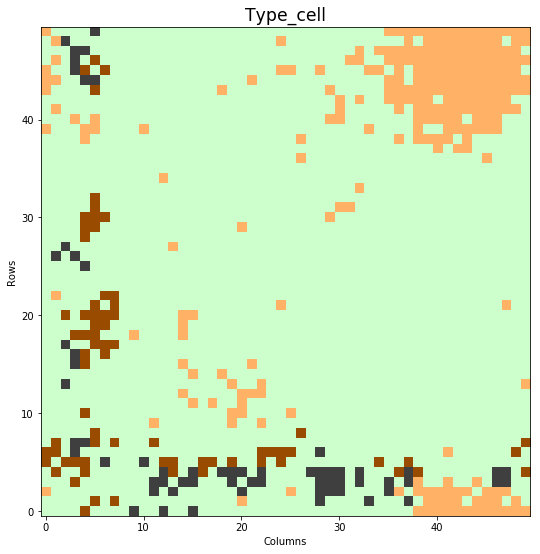

In [39]:
%time PlotAutomataHistory(results[max_steps][0])

CPU times: user 13.2 ms, sys: 2.36 ms, total: 15.5 ms
Wall time: 13.7 ms


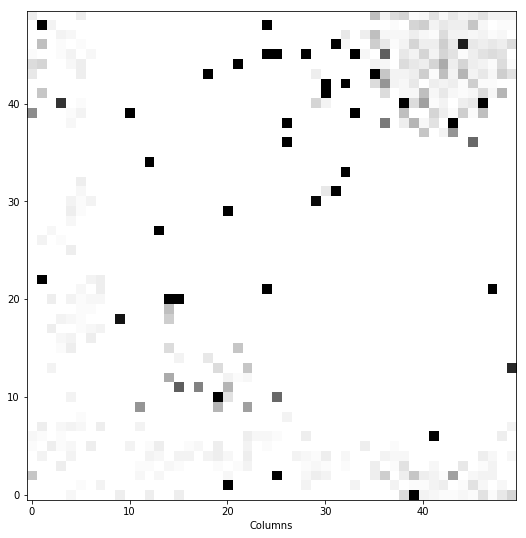

In [40]:
%time im1=PlotLifespan(results[max_steps][1])

<a id="animate"></a>
***

### Animate plot

In [41]:
%%capture
# Build plot

fig, ax = plt.subplots(figsize=(15,15))
fig2, ax1 = plt.subplots(figsize=(15,15))
resultsCopy= deepcopy(results)



def animate_type(j):
    ax.clear()
    PlotAutomataHistory(results[j][0],ax=ax)
    
def animate_life(j):
    ax1.clear()
    PlotLifespan(results[j][1],ax=ax1)
    
    
    
    
    
ani_type = matplotlib.animation.FuncAnimation(fig, animate_type, frames=len(results))
ani_life = matplotlib.animation.FuncAnimation(fig2, animate_life, frames=len(results))

In [43]:
ani_type #Animation of Type_cell

In [37]:
ani_life #Animation of Lifespan

<a id="plot_results"></a>
***


## Plot results 

<a id="func_fil"></a>
***

### Function for filtering out wanted attribute 
***

#### `filter_attribute` function 
The 4D Grid Results is filtered by `type_cell` and the wanted `attribute`. <br>

<b> returns</b> 3d List with the structure of `filtered[time_step][row][column]`
 <br>
<br>
#### `filter_type` function 
Uses `filter_attribute` to extract all the attributes related to `type_cell` <br>

`panda_structure`: `True / False`, is used to determine the format of the output.<br>

>`True`: attributes are first flatten and then converted into an table. <br> Tabel has the structure: rows represent the time steps and columns each cell in the grid. <br>

>`False`: attributes are 3D lists with the structure: `name[timestep][row][column]`

In [28]:
#PRE: 
    #Results= Results of the simulation with indexes:
        #[step][attribute][row][column]
    #type_cell of the wanted filter: [0,1,2,3,4]= representing the animals 
    #attribute for filtering the attribute in results [attribute] 
#POST: returns filtered with filtered[steps][row][column]

def filter_attribute(results,type_cell,attribute):
    filtered=np.zeros([max_steps+1,r_dim,c_dim])
    
    #print(attribute,"--------------ATTRIBUTE------------------")
    for t in range(max_steps+1):
        #print(t,"---------------STEP--------------")
        for i in range(r_dim):
            #print(i, "----------------ROW--------------")
            for j in range(c_dim):
                #print(j,"---------------COLUMN-------------")
                if type_cell==results[t][0][i][j]:
                    filtered[t][i][j]=results[t][attribute][i][j]
    #print(filtered)
    return filtered 


#PRE: 
    #Results= Results of the simulation with indexes:
        #[step][attribute][row][column]
    #type_cell, scalar (0,1,2,3,4), of which type_cell information should be extracted
    #Panda_structure, decides which format the data should have 
        #TRUE: Converts the extractet Lists into an Table with 
                #row= timesteps, 
                #columns= cells 
        #FALSE: Data stays in list form 

#POST: depending on Panda_structure bool it return either all the attributes 
        # in 3D list format or Flatten into a table 

def filter_type(results,type_cell,Panda_structure):
    
    type_c_m=filter_attribute(results,type_cell,0)
      
    #print("done type_cell",type_cell ,type_c_m)
    lifespan=filter_attribute(results,type_cell,1)
    #print("done lifespan",type_cell , lifespan)

    nutrition_level=filter_attribute(results,type_cell,2)
    #print("done nut",type_cell, nutrition_level)
    
    if Panda_structure:
        t_c_f=[time.flatten() for time in type_c_m]
        #print("type_cell", type_c_m)
        #print("type_cell", t_c_f)
        l_s_f=[time.flatten() for time in lifespan]
        #print("lifespan N", lifespan)
        #print("lifespan F", l_s_f)
        
        n_l_f=[time.flatten() for time in nutrition_level]
        #print("Nu N", nutrition_level)
        #print("Nu F", n_l_f)
        
        df_type= pd.DataFrame(t_c_f)
        #print("type",df_type)
        df_life= pd.DataFrame(l_s_f)
        #print("life",df_life)
        
        df_nutri= pd.DataFrame(n_l_f)
        #print("nutri",df_nutri)
        
        return df_type, df_life, df_nutri
    
    return type_c_m, lifespan, nutrition_level
    
    

***

#### Filtering all attributes of `type_cell` [1,2,3,4]
    


In [29]:
#For checking if everything worked:
#T0,L0,R0,N0=filter_type(results,0,True)

T1,L1,N1=filter_type(results,1,True) #Rabbit
T2,L2,N2=filter_type(results,2,True) #Wolf
T3,L3,N3=filter_type(results,3,True) #Deer
T4,L4,N4=filter_type(results,4,True) #Bear

<a id="format"></a>
***


### Format Data for plots

In [30]:
x=np.arange(0.0,max_steps+1,1)

#Variables for plotting 

size=(10,7) #size plot
width=1.5   #linewidth
font='large'#fontsize
fonttitle='x-large'#fonttitle size


#Total of type_cell in grid of each timestep
R_t=T1[T1==1].count(axis='columns') #Rabbit
W_t=T2[T2==2].count(axis='columns') #Wolves
D_t=T3[T3==3].count(axis='columns') #Deer
B_t=T4[T4==4].count(axis='columns') #Bear

#Total livespan in grid of each timestep
R_l=L1.sum(axis='columns')
W_l=L2.sum(axis='columns')
D_l=L3.sum(axis='columns')
B_l=L4.sum(axis='columns')


#Total of lifespan per type_cell in grid of each timestep
R_L_P=R_l.div(R_t)
W_L_P=W_l.div(W_t)
D_L_P=D_l.div(D_t)
B_L_P=B_l.div(B_t)

#fill Series Nan with 0
R_L_P=R_L_P.fillna(0)
W_L_P=W_L_P.fillna(0)
D_L_P=D_L_P.fillna(0)
B_L_P=B_L_P.fillna(0)

#Counter of Offspring
#R_r=R1.sum(axis='columns')
#W_r=R2.sum(axis='columns')
#D_r=R3.sum(axis='columns')
#B_r=R4.sum(axis='columns')

#Total Nutrition level of all type_cell in grid of each timestep
R_n=N1.sum(axis='columns')
W_n=N2.sum(axis='columns')
D_n=N3.sum(axis='columns')
B_n=N4.sum(axis='columns')

#Total of lifespan per type_cell in grid of each timestp
R_N_P=R_n.div(R_t)
W_N_P=W_n.div(W_t)
D_N_P=D_n.div(D_t)
B_N_P=B_n.div(B_t)

#fill Series Nan with 0
R_N_P=R_n.fillna(0)
W_N_P=W_n.fillna(0)
D_N_P=D_n.fillna(0)
B_N_P=B_n.fillna(0)


<a id="plot_res"></a>
***

# Results

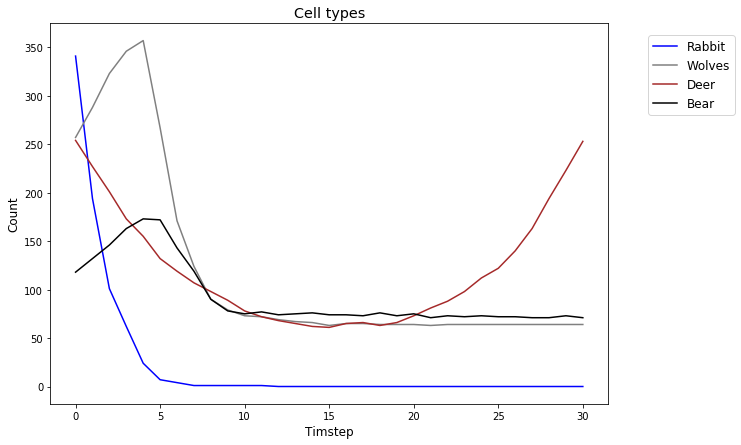

In [31]:
plt.figure(figsize=size)
plt.plot(x,R_t,'blue',linewidth=width, label='Rabbit')
plt.plot(x,W_t,'grey',linewidth=width, label='Wolves')
plt.plot(x,D_t,'brown',linewidth=width,label='Deer')
plt.plot(x,B_t,'black',linewidth=width,label='Bear')
plt.xlabel('Timstep',fontsize=font)
plt.ylabel('Count',fontsize=font)
plt.title('Cell types',fontsize=fonttitle)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.,fontsize=font)
plt.show()

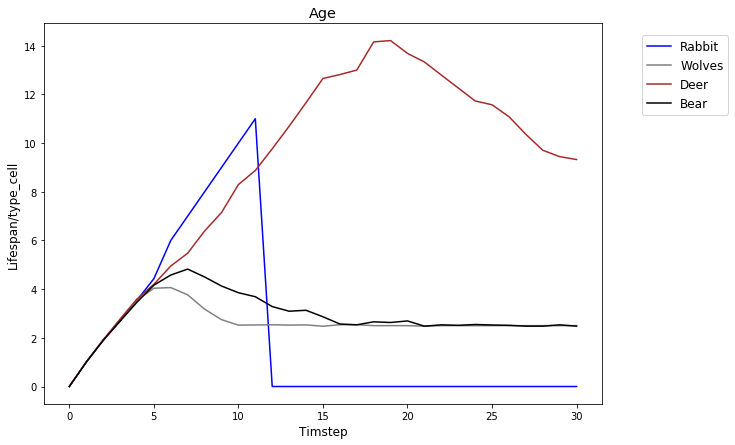

In [32]:
plt.figure(figsize=size)
plt.plot(x,R_L_P,'blue',linewidth=width, label='Rabbit')
plt.plot(x,W_L_P,'grey',linewidth=width, label='Wolves')
plt.plot(x,D_L_P,'brown',linewidth=width,label='Deer')
plt.plot(x,B_L_P,'black',linewidth=width,label='Bear')
plt.xlabel('Timstep',fontsize=font)
plt.ylabel('Lifespan/type_cell',fontsize=font)
plt.title('Age',fontsize=fonttitle)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.,fontsize=font)
plt.show()

In [33]:
#plt.figure(figsize=size)
#plt.plot(x,R_r,'blue',linewidth=width, label='Rabbit')
#plt.plot(x,W_r,'grey',linewidth=width, label='Wolves')
#plt.plot(x,D_r,'brown',linewidth=width,label='Deer')
#plt.plot(x,B_r,'black',linewidth=width,label='Bear')
#plt.xlabel('Timstep',fontsize=font)
#plt.ylabel('Count of reproduction ',fontsize=font)
#plt.title('Reproduction',fontsize=fonttitle)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.,fontsize=font)
#plt.show()

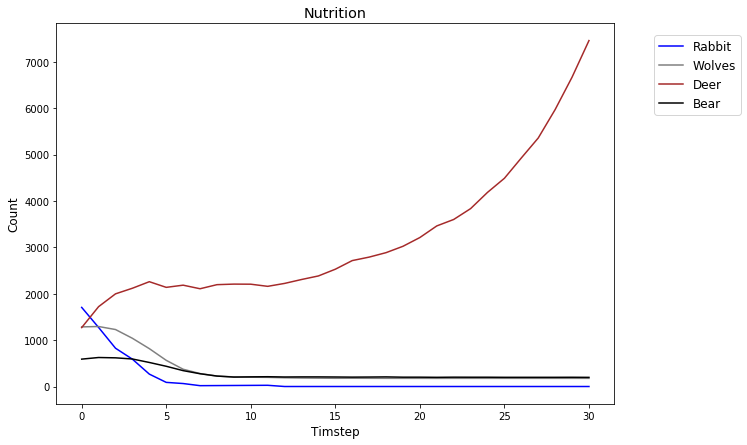

In [34]:
plt.figure(figsize=size)
plt.plot(x,R_N_P,'blue',linewidth=width, label='Rabbit')
plt.plot(x,W_N_P,'grey',linewidth=width, label='Wolves')
plt.plot(x,D_N_P,'brown',linewidth=width,label='Deer')
plt.plot(x,B_N_P,'black',linewidth=width,label='Bear')
plt.xlabel('Timstep',fontsize=font)
plt.ylabel('Count',fontsize=font)
plt.title('Nutrition',fontsize=fonttitle)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.,fontsize=font)
plt.show()

<a id="data_set"></a>
***

## Create Data set and export it

In [35]:

#Creat list with all important imformation of a type_cell 
Rabbit=pd.concat([R_t,R_L_P,R_N_P,R_r], axis=1)
Rabbit.columns=list(["Count","Lifespan","Nutrition","Reproduction"])

Wolves=pd.concat([W_t,W_L_P,W_N_P,W_r], axis=1)
Wolves.columns=list(["Count","Lifespan","Nutrition","Reproduction"])

Deer=pd.concat([D_t,D_L_P,D_N_P,D_r], axis=1)
Deer.columns=list(["Count","Lifespan","Nutrition","Reproduction"])

Bear=pd.concat([B_t,B_L_P,B_N_P,B_r], axis=1)
Bear.columns=list(["Count","Lifespan","Nutrition","Reproduction"])




NameError: name 'R_r' is not defined

In [ ]:
#UNCOMMENT IF RESULTS ARE WANTED, ADJUST PATH 

#Rabbit.to_csv(r'/Users/parisanton/Dropbox/ETH/HS 18/Gess Fächer/Matlab/Raw Data/Report_Rabbits.csv')
#Wolves.to_csv(r'/Users/parisanton/Dropbox/ETH/HS 18/Gess Fächer/Matlab/Raw Data/Report_Wolves.csv')
#Deer.to_csv(r'/Users/parisanton/Dropbox/ETH/HS 18/Gess Fächer/Matlab/Raw Data/Report_Deer.csv')
#Bear.to_csv(r'/Users/parisanton/Dropbox/ETH/HS 18/Gess Fächer/Matlab/Raw Data/Report_Bear.csv')